In [92]:
!pip install mne

In [93]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [94]:
subject_ids = range(1, 51)
runs = [5, 9, 13]

X_all = []
y_all = []

In [95]:
print(f"Load data: {subject_ids}...")

for subject_id in subject_ids:
    try:
        fnames = mne.datasets.eegbci.load_data(subject_id, runs, verbose=False)
        raw = mne.io.concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in fnames])

        mne.datasets.eegbci.standardize(raw)

        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)


        # PREPROCESSING
        # Filter 0.5 - 40 Hz untuk menangkap MRCP (low freq) dan Beta (high freq)
        # serta membuang noise otot frekuensi tinggi (>40Hz)
        raw.filter(0.5, 40.0, fir_design='firwin', verbose=False)
        events, event_id = mne.events_from_annotations(raw, verbose=False)

        # Mapping label: T1 (Hands) -> 0, T2 (Feet) -> 1
        picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

        # Epoching
        tmin, tmax = 0, 2.0
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                            baseline=None, preload=True, verbose=False)

        X = epochs.get_data()
        y = epochs.events[:, -1]

        # Konversi label agar menjadi binary 0 dan 1
        # Menormalisasi y menjadi 0 dan 1
        unique_y = np.unique(y)
        y = np.where(y == unique_y[0], 0, 1)

        X_all.append(X)
        y_all.append(y)

    except Exception as e:
        print(f"Error pada subjek {subject_id}: {e}")

Load data: range(1, 51)...


In [96]:
X = np.concatenate(X_all, axis=0)
y = np.concatenate(y_all, axis=0)

print(f"\nTotal Data Shape: {X.shape}")
print(f"Total Label Shape: {y.shape}")


Total Data Shape: (4500, 64, 321)
Total Label Shape: (4500,)


In [97]:
# Split Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [98]:
# Ubah dari (Batch, Channel, Time) -> (Batch, Time, Channel)
X_train_1d = np.transpose(X_train, (0, 2, 1))
X_val_1d   = np.transpose(X_val, (0, 2, 1))
X_test_1d  = np.transpose(X_test, (0, 2, 1))

In [99]:
# Scaling (StandardScaler)
scaler = StandardScaler()

# Fungsi helper untuk scaling 3D data
def scale_data(data_3d, scaler, fit=False):
    N, T, C = data_3d.shape
    data_2d = data_3d.reshape(N * T, C)
    if fit:
        scaler.fit(data_2d)
    data_scaled_2d = scaler.transform(data_2d)
    return data_scaled_2d.reshape(N, T, C)

X_train_1d = scale_data(X_train_1d, scaler, fit=True)
X_val_1d   = scale_data(X_val_1d, scaler)
X_test_1d  = scale_data(X_test_1d, scaler)

print(f"\nShape Input Network (Train): {X_train_1d.shape}")


Shape Input Network (Train): (2880, 321, 64)


In [100]:
n_timesteps = X_train_1d.shape[1]
n_features  = X_train_1d.shape[2]

model = Sequential()
model.add(Input(shape=(n_timesteps, n_features)))

reg_strength = 0.04

model.add(Conv1D(filters=8, kernel_size=64, padding='same', activation='elu',
                 kernel_regularizer=l2(reg_strength)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4)) # Output: 320 -> 80
model.add(Dropout(0.5))

model.add(Conv1D(filters=16, kernel_size=32, padding='same', activation='elu',
                 kernel_regularizer=l2(reg_strength)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4)) # Output: 80 -> 20
model.add(Dropout(0.5))

model.add(Conv1D(filters=32, kernel_size=16, padding='same', activation='elu',
                 kernel_regularizer=l2(reg_strength)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))


model.add(GlobalAveragePooling1D())
model.add(Dense(8, activation='elu', kernel_regularizer=l2(reg_strength)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 321, 8)         │        32,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 321, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 80, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 80, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 80, 16)         │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 80, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 20, 32)         │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 20, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,609 (178.16 KB)

 Trainable params: 45,497 (177.72 KB)

 Non-trainable params: 112 (448.00 B)

In [101]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [102]:
history = model.fit(
    X_train_1d, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val_1d, y_val),
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.5118 - loss: 3.0949 - val_accuracy: 0.5236 - val_loss: 2.4011 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5436 - loss: 2.2801 - val_accuracy: 0.6375 - val_loss: 1.7916 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5521 - loss: 1.7328 - val_accuracy: 0.6736 - val_loss: 1.4143 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6143 - loss: 1.3656 - val_accuracy: 0.6931 - val_loss: 1.1806 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6566 - loss: 1.1497 - val_accuracy: 0.7319 - val_loss: 1.0275 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6719 - loss: 1.0128 - val_accuracy: 0.7083 - val_loss: 0.9239 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6819 - loss: 0.9177 

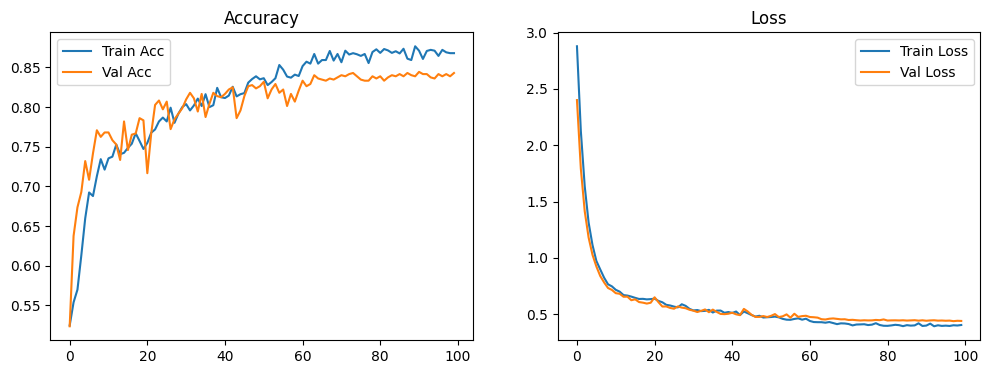

In [103]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

--- Classification Result (Test Set) ---
                 precision    recall  f1-score   support

Class 0 (Hands)       0.84      0.86      0.85       450
 Class 1 (Feet)       0.86      0.83      0.84       450

       accuracy                           0.85       900
      macro avg       0.85      0.85      0.85       900
   weighted avg       0.85      0.85      0.85       900


--- Confusion Matrix ---


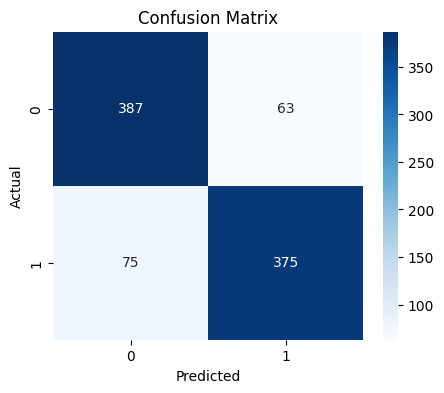

In [104]:
y_pred_proba = model.predict(X_test_1d)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n--- Classification Result (Test Set) ---")
print(classification_report(y_test, y_pred, target_names=['Class 0 (Hands)', 'Class 1 (Feet)']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()